In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from matplotlib.pyplot import rcParams

import xarray as xr
import numpy as np
import scipy as sp

import soundings as sd
import classification as cl


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
%load_ext autoreload
%autoreload 1
%aimport soundings
%aimport classification

In [3]:
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings.nc')
ACCESS_C_soundings = xr.open_dataset('ACCESS_C_soundings.nc')
ERA5_soundings = xr.open_dataset('ERA5_soundings.nc')
ERA5_soundings['p'].values = ERA5_soundings['p'].values*1e2

times_1 = set(ACCESS_G_soundings['time'].values)
times_2 = set(ACCESS_C_soundings['time'].values)
times_3 = set(ERA5_soundings['time'].values)
common_times = sorted(list(
    times_1.intersection(times_2).intersection(times_3)))

In [4]:
times_2

{numpy.datetime64('2021-01-01T00:00:00.000000000'),
 numpy.datetime64('2021-01-02T00:00:00.000000000'),
 numpy.datetime64('2021-01-03T00:00:00.000000000'),
 numpy.datetime64('2021-01-04T00:00:00.000000000'),
 numpy.datetime64('2021-01-05T00:00:00.000000000'),
 numpy.datetime64('2021-01-06T00:00:00.000000000'),
 numpy.datetime64('2021-01-07T00:00:00.000000000'),
 numpy.datetime64('2021-01-08T00:00:00.000000000'),
 numpy.datetime64('2021-01-09T00:00:00.000000000'),
 numpy.datetime64('2021-01-11T00:00:00.000000000'),
 numpy.datetime64('2021-01-12T00:00:00.000000000'),
 numpy.datetime64('2021-01-13T00:00:00.000000000'),
 numpy.datetime64('2021-01-14T00:00:00.000000000'),
 numpy.datetime64('2021-01-15T00:00:00.000000000'),
 numpy.datetime64('2021-01-16T00:00:00.000000000'),
 numpy.datetime64('2021-01-17T00:00:00.000000000'),
 numpy.datetime64('2021-01-18T00:00:00.000000000'),
 numpy.datetime64('2021-01-19T00:00:00.000000000'),
 numpy.datetime64('2021-01-20T00:00:00.000000000'),
 numpy.datet

In [281]:
hours = [6]
days = 'all'

soundings_list = [ACCESS_G_soundings, ACCESS_C_soundings, ERA5_soundings]
new_soundings_list = []

for soundings in soundings_list:

    soundings = soundings.sel(time=common_times)
    soundings = soundings.where(
        soundings['pope_regime'] == 2).dropna(dim='time')
    if days != 'all':
        soundings = soundings.sel(time=days)
    soundings = soundings.sel(hour=hours)
    soundings = soundings.mean(dim=['hour', 'time'])
    new_soundings_list.append(soundings)

[
    ACCESS_G_soundings, 
    ACCESS_C_soundings, 
    ERA5_soundings] = new_soundings_list

ValueError: dimensions or multi-index levels ['time'] do not exist

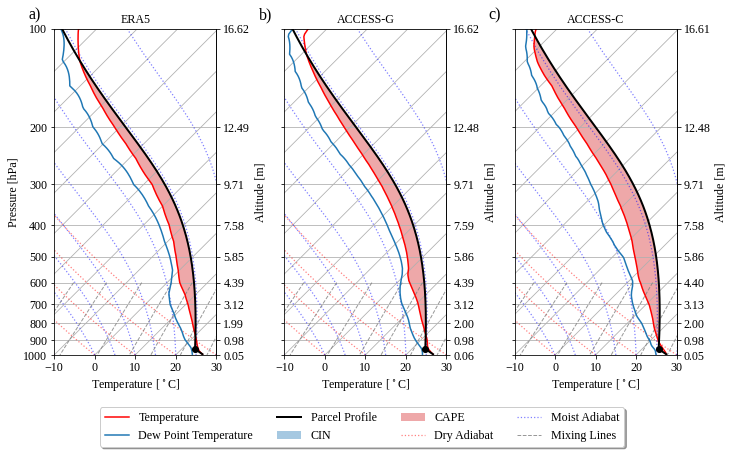

In [282]:
figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = sd.plot_skewt(
    ERA5_soundings, fig=fig, subplots=(1, 3, 1), legend=False, 
    right_ticks=False, title='ERA5')
ax2 = sd.plot_skewt(
    ACCESS_G_soundings, fig=fig, subplots=(1, 3, 2), legend=False,
    left_ticks=False, right_ticks=True, title='ACCESS-G')
ax3 = sd.plot_skewt(
    ACCESS_C_soundings, fig=fig, subplots=(1, 3, 3), legend=False,
    left_ticks=False, title='ACCESS-C')
plt.subplots_adjust(wspace=.1)

cl.make_subplot_labels([ax1, ax2, ax3], x_shift=-.16, y_shift=.03)

ax1.legend(
    loc='lower center', bbox_to_anchor=(1.9, -0.3),
    ncol=4, fancybox=True, shadow=True)